In [1]:
from itertools import islice, cycle
from tau_profile_parser import TauProfileParser
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px


In [2]:
multi_files = TauProfileParser.parse('/home/users/MTrappett/multi_nov_4_openmp_papi',MULTI=True)

In [3]:
time_sorted = multi_files.interval_data().sort_values(by=[('Exclusive','TIME')], ascending=False)

In [4]:
time_sorted[time_sorted['Timer Name'].str.match('OpenMP_Implicit_Task')]

Intervals                                 Calls Subcalls ProfileCalls  \
Metric                                                                  
Node Context Thread Timer                                               
0    0       7      OpenMP_Implicit_Task  49200        0            0   
             4      OpenMP_Implicit_Task  49200        0            0   
             1      OpenMP_Implicit_Task  49200        0            0   
             3      OpenMP_Implicit_Task  49200        0            0   
             2      OpenMP_Implicit_Task  49200        0            0   
             6      OpenMP_Implicit_Task  49200        0            0   
             5      OpenMP_Implicit_Task  49200        0            0   
             0      OpenMP_Implicit_Task  49200        0            0   

Intervals                                              Group  \
Metric                                                         
Node Context Thread Timer                                      
0    0       7      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             4      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             1      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             3      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             2      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             6      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             5      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   
             0      OpenMP_Implicit_Task  GROUP="TAU_OPENMP"   

Intervals                                           Timer Name Timer Location  \
Metric                                                                          
Node Context Thread Timer                                                       
0    0       7      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             4      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             1      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             3      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             2      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             6      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             5      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   
             0      OpenMP_Implicit_Task  OpenMP_Implicit_Task           None   

Intervals                                Timer Type   Exclusive               \
Metric                                              PAPI_FP_OPS PAPI_TOT_CYC   
Node Context Thread Timer                                                      
0    0       7      OpenMP_Implicit_Task       None   817414997   6469241815   
             4      OpenMP_Implicit_Task       None   819760325   6402530837   
             1      OpenMP_Implicit_Task       None   819817676   6385991682   
             3      OpenMP_Implicit_Task       None   819689197   6441373854   
             2      OpenMP_Implicit_Task       None   819948210   6331088257   
             6      OpenMP_Implicit_Task       None   819498597   6205569911   
             5      OpenMP_Implicit_Task       None   819524097   6150944395   
             0      OpenMP_Implicit_Task       None   817616770   4334557542   

Intervals                                                        Inclusive  \
Metric                                   PAPI_TOT_INS     TIME PAPI_FP_OPS   
Node Context Thread Timer                                                    
0    0       7      OpenMP_Implicit_Task   9426136375  1977460   817414997   
             4      OpenMP_Implicit_Task   9162625539  1942309   819760325   
             1      OpenMP_Implicit_Task   9228236135  1940445   819817676   
             3      OpenMP_Implicit_Task   9070296676  1924704   819689197   
             2      OpenMP_Implicit_Task   9087243619  1923133   819948210   
             6      OpenMP_Implicit_Task   8695341952  1893233   819498597   
             5  

### Removing Timers
I removed OpenMP_Thread_Type_ompt_thread_worker, .TAU application, and OpenMP_Implicity_Task from the data so that we can just work with smaller functions. 
I used a method of just taking 2 sub DF's from the time_sorted, concat them together and then drop_duplicates(). The logic for finding which lines is demonstrated above. This was an example I found on stack overflow: https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe combined with this example: https://davidhamann.de/2017/06/26/pandas-select-elements-by-string/ .



In [5]:
time_sorted = pd.concat([time_sorted,time_sorted[time_sorted['Timer Name'].str.match('OpenMP_Implicit_Task')],time_sorted[time_sorted['Timer Name'].str.match('OpenMP_Implicit_Task')]]).drop_duplicates(keep=False)

In [6]:
time_sorted = pd.concat([time_sorted,time_sorted[time_sorted['Timer Name'].str.match('.TAU application')],time_sorted[time_sorted['Timer Name'].str.match('.TAU application')]]).drop_duplicates(keep=False)

In [7]:
time_sorted = pd.concat([time_sorted,time_sorted[time_sorted['Timer Name'].str.match('OpenMP_Thread_Type_ompt_thread_worker')],time_sorted[time_sorted['Timer Name'].str.match('OpenMP_Thread_Type_ompt_thread_worker')]]).drop_duplicates(keep=False)

# Selecting Columns for Waffle Plot
We can select any of the columns we would like to analyze. Waffle plot would only be useful for a few Items at best.

In [8]:
import matplotlib.pyplot as plt 
from pywaffle import Waffle

In [9]:
slimmed = pd.concat([time_sorted[['Timer Name']],time_sorted[('Exclusive','TIME')]], axis=1)
slimmed_wo_index = slimmed.reset_index()
slim_timer = slimmed_wo_index['Timer Name']
slim_TIME = slimmed_wo_index[('Exclusive', 'TIME')]


In [10]:
slim_timer_time = pd.concat([slimmed_wo_index['Timer Name'],slimmed_wo_index[('Exclusive', 'TIME')]],axis=1)
slim_timer_time.head(10)

,Timer Name,"(Exclusive, TIME)"
0,OpenMP_Parallel_Region CalcPressureForElems,141372
1,OpenMP_Parallel_Region CalcPressureForElems,94586
2,OpenMP_Parallel_Region EvalEOSForElems(Domain&...,48421
3,OpenMP_Parallel_Region CalcEnergyForElems,47659
4,OpenMP_Parallel_Region CalcEnergyForElems,47256
5,OpenMP_Parallel_Region CalcEnergyForElems,47236
6,OpenMP_Parallel_Region CalcEnergyForElems,47066
7,OpenMP_Parallel_Region CalcEnergyForElems,46970
8,OpenMP_Parallel_Region CalcEnergyForElems,46779
9,OpenMP_Parallel_Region CalcSoundSpeedForElems,15017


#### We want the (Exclusive,TIME) column to be a smaller amount to compare them.

In [11]:
reducing_factor = 10000
slim_timer_time[('Exclusive','TIME')] = slim_timer_time[('Exclusive','TIME')].apply(lambda x: x/reducing_factor)


Calculating the `other` if we wanted to include it for comparison of functions, but it is so big that it would drown out our analysis of the top functions.


In [12]:
other = slim_timer_time[5:].sum()


### Waffle Plot
The library pyWaffle can be downloaded using `pip install pywaffle`. Some other examples are found on their GitHub: https://github.com/gyli/PyWaffle. Waffle plots get increasingly difficult to read when there are more than a few elements in the plot. I selected the top five functions based on time to demonstrate. 

/home/users/MTrappett/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


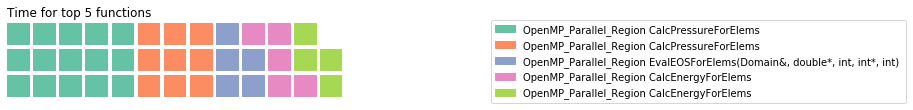

In [13]:
fig = plt.figure( 
    FigureClass = Waffle, 
    rows = 3, 
    values = slim_timer_time[('Exclusive','TIME')][:5], 
    labels = list(slim_timer_time['Timer Name'][:5]) ,
    legend={'loc': 'best','bbox_to_anchor': (2.7,1.1)},
    title={'label': 'Time for top 5 functions', 'loc': 'left'},
) 